# Parameters

In [10]:
TRACEFILE = "./MsgTraces_W5_load-80p_0.tr"

In [11]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
messages_allsizes: List[int] = []

with open(TRACEFILE, "r") as f:
    for line in f:
        log = line.split()
        ts = float(log[1]) * 1e-9   # seconds
        sz = int(log[2])            # bytes
        sender = log[3]             # ip:port
        receiver = log[4]             # ip:port
        txid = int(log[5])

        key = Message.get_key(sender, receiver, txid)

        if log[0] == "+":
            msg = Message(sender, receiver, txid, sz)
            msg.start_ts = ts
            messages[key].append(msg)
        elif log[0] == "-":
            msg = next((m for m in messages[key] if m.end_ts == 0), None)
            if not msg:
                print("ERROR: cannot find start entry for ", line)
                continue
            
            if msg.end_ts:
                print("Message already has an end_ts!", msg)
                continue
            
            msg.end_ts = ts
            messages_allsizes.append(msg.sz)
            messages_size2delays[msg.sz].append(msg.completion_time)

all_messages_list = []
for msgs in list(messages.values()):
    all_messages_list.extend(msgs)

In [12]:
# for msg in all_messages_list:
#     print(msg)

In [13]:

import numpy as np
from scipy import stats

messages_allsizes = np.array(messages_allsizes)
msg_size_percentiles = stats.rankdata(messages_allsizes, "max")/len(messages_allsizes) * 100


In [14]:
# some basic statistics

print("Total number of messages:", len(all_messages_list))
print("Total number of distinct message sizes:", len(messages_size2delays))

num_incomplete = len([msg for msg in all_messages_list if msg.end_ts == 0])
print("Number of incomplete messages: %s" % num_incomplete)

# sorted_sizes = sorted(messages_size2delays.keys())
# for i, sz in enumerate(sorted_sizes):
#     if i == 0:
#         print(sz)
#     else:
#         print(f"{sz} +{sz - sorted_sizes[i - 1]}")


Total number of messages: 528330
Total number of distinct message sizes: 400
Number of incomplete messages: 0


In [15]:
import matplotlib.pyplot as plt


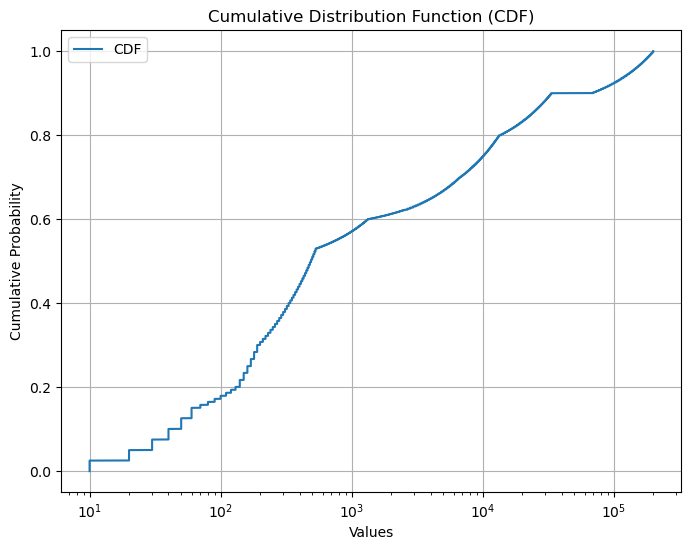

In [16]:
# basic CDF of message sizes

# Sorting the data
sorted_data = np.sort(messages_allsizes)

# Calculating the cumulative distribution
cdf = np.linspace(0, 1, len(sorted_data))

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, label='CDF')

plt.xscale("log")

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

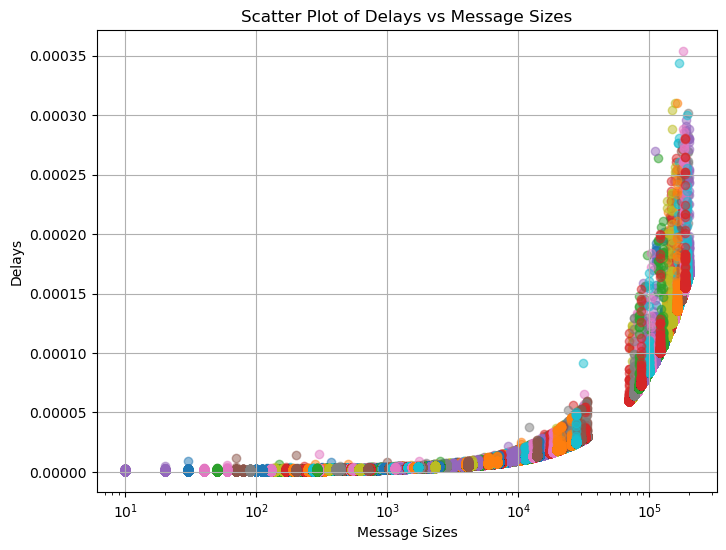

In [17]:
# a basic plot of messages sizes vs total delay
# nothing to see here -- pretty linear as expected.

plt.figure(figsize=(8, 6))

for message_size, delays in messages_size2delays.items():
    plt.scatter([message_size] * len(delays), delays, label=f'Message Size {message_size}', alpha=0.5)

plt.xscale('log')  # does log scale make sense here?

# Set labels and title
plt.xlabel('Message Sizes')
plt.ylabel('Delays')
plt.title('Scatter Plot of Delays vs Message Sizes')

# Show the plot
plt.grid(True)
plt.show()

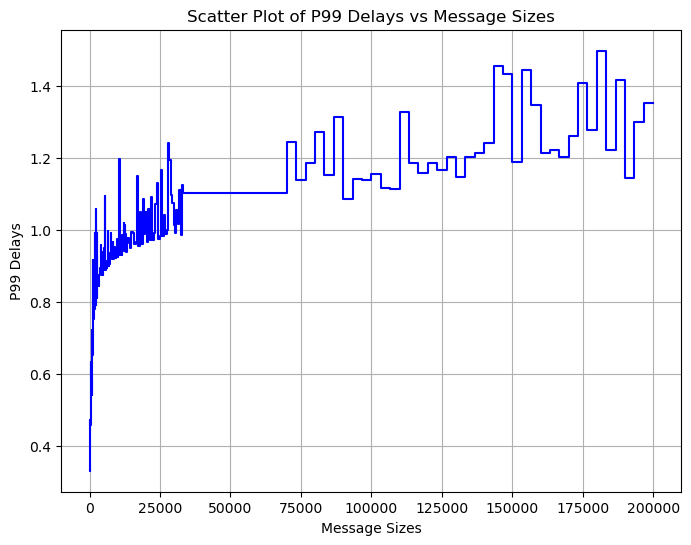

In [18]:
# this time, we calculate the *SLOWDOWN*.

import math

PACKET_PAYLOAD_SIZE_BYTES = 1460
PACKET_HEADER_SIZE_BYTES = 40
PACKET_SIZE = PACKET_PAYLOAD_SIZE_BYTES + PACKET_HEADER_SIZE_BYTES
TOR_BANDWIDTH = 10e9
SPINE_BANDWIDTH = 40e9

# how the fuck are these numbers derived?
ONE_WAY_DELAY = 1.0e-6 + PACKET_SIZE * 8 * (2 / TOR_BANDWIDTH + 2 / SPINE_BANDWIDTH)
BASE_RTT = ONE_WAY_DELAY + 1.0e-6 + 64 * 8 * (2 / TOR_BANDWIDTH + 2 / SPINE_BANDWIDTH)

BDP_PACKETS = 7

messages_size2slowdown_p99: Dict[int, float] = defaultdict(float)

for msg_sz, msg_delays in messages_size2delays.items():
    delays = np.array(msg_delays)
    p50_delay = np.percentile(delays, 50)
    p99_delay = np.percentile(delays, 99)

    npackets = math.ceil(msg_sz / PACKET_PAYLOAD_SIZE_BYTES)
    nbytes = msg_sz + PACKET_HEADER_SIZE_BYTES * npackets

    base_delay = nbytes * 8 / TOR_BANDWIDTH + ONE_WAY_DELAY; # bits per second
    p99_slowdown = p99_delay / base_delay

    messages_size2slowdown_p99[msg_sz] = p99_slowdown

msg_sz = sorted(messages_size2slowdown_p99.keys())
msg_p99slowdown = [messages_size2slowdown_p99[sz] for sz in msg_sz]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.step(msg_sz, msg_p99slowdown, linestyle='-', color='blue')

# Set labels and title
plt.xlabel('Message Sizes')
plt.ylabel('P99 Delays')
plt.title('Scatter Plot of P99 Delays vs Message Sizes')

# Show grid
plt.grid(True)

# Show the plot
plt.show()